<a href="https://colab.research.google.com/github/rosieiiiii/KR_return_example/blob/main/KR_return_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we provide an example of using the kernel ridge (KR) model for zero-coupon bond returns estimation using U.S. Treasury data. This notebook runs on Google Colab.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps 
import time
import sys
import os
import pickle

## download KR example files from Github
if not os.path.exists('KR_return_example'):
    !git clone https://github.com/rosieiiiii/KR_return_example.git
dir_kr = '/content/KR_return_example/'

sys.path.append(dir_kr+'source/')
import models
import kernel


# Generating kernel matrix
KR has three hyper-parameters: $\alpha$, $\delta$, and $\lambda$, among which $\alpha$ and $\delta$ are shape hyper-parameters that determine the kernel matrix. For a fixed pair of $\alpha$ and $\delta$, we need to generate a kernel matrix only once, which can be shared across multiple cross-sections. $\lambda$ controls the degree of smoothness and model complexity. Baseline values for these three hyper-parameters are $\alpha=0.05$, $\delta=0$, and $\lambda=1$.

In this example, we generate a kernel matrix of dimension $N$-by-$N$, where $N$ is the maximum time-to-maturity of the discount curve that we are about to estimate. $N$ needs to be no less than the maximum time-to-maturity in days $N'$ of securities in the data so that pricing error can be calculated. When $N>N'$, we also obtain extrapolated curve estimates.

In [ ]:
### settings
# kernel hyper-parameters
alpha = 0.05
delta = 0.00

# max time to maturity in days
N = 10*365

start_time = time.time()
K = kernel.generate_kernel_matrix(alpha, delta, N, N)
end_time = time.time()

print('Time elapsed for generating a {}-by-{} kernel matrix with alpha = {} and delta = {}: {:.1f} sec'\
      .format(N,N,alpha, delta, end_time-start_time))

# SVD
U,D_diag,Vh = np.linalg.svd(K)
V = Vh.T
D = np.diag(D_diag) # D is a matrix
DV_inv = V@np.diag(1/np.sqrt(D_diag))
assert np.isclose(U[:,:10],V[:,:10]).all()

dict_svd = {'V':V,
            'D_diag':D_diag,
            'DV_inv':DV_inv}

Time elapsed for generating a 3650-by-3650 kernel matrix with alpha = 0.05 and delta = 0.0: 1.2 sec


# Load data

Price and cashflow data are contained in vector $B$ of dimension $M$ and matrix $C$ of dimension $M$-by-$N'$. $M$ is the number of securities in the cross-section. $N'$ is the maximum time-to-maturity in days of the data. For example, assume that there are three securities with prices 0.99, 0.98, and 0.97 maturing in 1, 3, and 5 days. Each of these securities has only one cash flow with value 1 due at maturity. Then, $B$ and $C$ take the following form:

$$B =
\begin{pmatrix}
0.99\\
0.98\\
0.97
\end{pmatrix}, 
$$

$$
C = 
\begin{pmatrix}
1 & 0 & 0 & 0& 0\\
0 & 0 & 1 & 0& 0\\
0 & 0 & 0 & 0& 1\\
\end{pmatrix}.
$$

In this example, $M=3$ and $N'=5$.

In the code block below, we load the data needed to estiamte returns on 1986-06-30 and 2013-12-31 relative to the next business day, 1986-07-01 and 2014-01-02. For each example date, we have:
- **date_s** is the number of days to the next business day
- **B** is the ex-dividend price vector
- **Bc_shift** is the shifted cum-dividend price vector
- **C** is the cashflow matrix
- **rf_t** is risk-free rate on example date t
- **g** is the daily discount curve

In [ ]:
### load example data
dir_data = dir_kr + 'example_data/'
example_dates=['1986-06-30', '2013-12-31']

with open(dir_data + 'dict_data.pkl','rb') as handle:
    dict_data = pickle.load(handle)
print(dict_data['1986-06-30'].keys())

dict_keys(['date_s', 'B', 'Bc_shift', 'C', 'rf_t', 'g'])


# Fit KR return model on example dates


In [ ]:
### fit KR return model on example dates

l_fixed = 10.0 
R = 10
lst_R_fit = None

start_time = time.time()

dict_out = {}
for date in example_dates:
    
    B = dict_data[date]['B']
    Bc_shift = dict_data[date]['Bc_shift']
    C = dict_data[date]['C']
    date_s = dict_data[date]['date_s']
    nt=len(B)
    
    # normalize prices to 1
    Bc_shift = (1/B)*Bc_shift
    C = (1/B)[:,np.newaxis]*C
    B = np.ones(nt)*1
    
    # get return of securities
    rf = (1+dict_data[date]['rf_t'])**date_s-1 # scalar
    ret = (Bc_shift-B)/B
    rx = ret-rf
    
    Z_bar = C[:,date_s-1:]@np.diag(dict_data[date]['g'][date_s-1:N]) # dim: (nt, Nmax-date_s+1)
    Z = Z_bar[:,1:] # dim: (nt, Nmax-date_s)

    dict_full = models.one_fit(Z=Z,
                l_unscaled=l_fixed,
                rx=rx, # (Bc_shift-B)/B - rf
                date_s=date_s, # number of day shifts
                K=K # 2D, specific to alpha
                )

    # factor model
    dict_fm = models.FM_ridge_solution(Z=Z,
            l_unscaled=l_fixed,
            rx=rx, # (Bc_shift-B)/B - rf
            date_s=date_s, # number of day shifts
            V=dict_svd['V'], # svd of K
            D_diag=dict_svd['D_diag'], # svd of K
            R=R, # max number of factors
            lst_R_fit=lst_R_fit # list of r used for fitting. will override R above
            )
    
    dict_out[date] = {
                  'rx': rx, # rx of underlying securities
                  'ret':ret, # ret of underlying securities
                  'date_s':date_s, # date spacing
                  'rf':rf, # compounded rf with date_s
                  'dict_full':dict_full,
                  'dict_fm':dict_fm
                 }

end_time = time.time()

print('Time elapsed for fitting KR model for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Time elapsed for fitting KR model for 2 example dates: 0.6 sec


# Plot fitted curves

The code block below plots fitted excess returns up to the maximum time-to-maturity $N'$ in the data and the fitted excess return curve. 

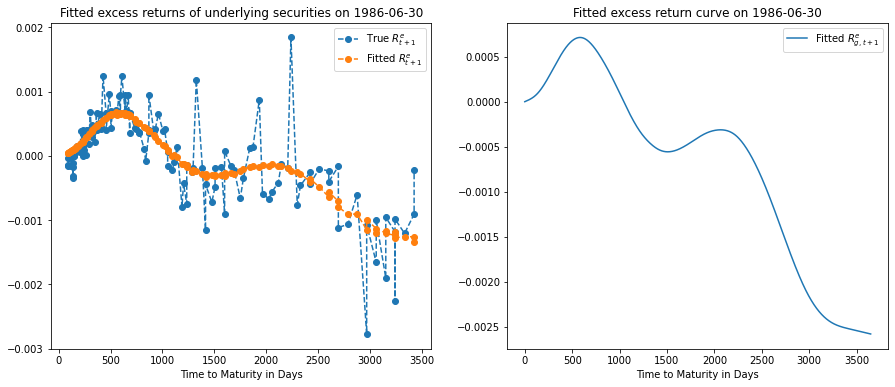

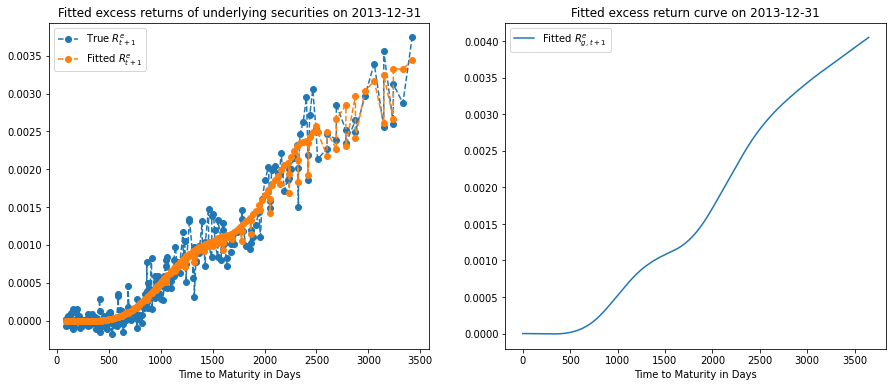

In [ ]:
for date in example_dates:
    
    dict_t = dict_out[date]
    C = dict_data[date]['C']
    
    # get ttm in day for further analysis
    lst_ttm_inday = np.apply_along_axis(lambda row: len(row)-(row!=0)[::-1].argmax(),1,C)
    
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
    
    rx_g_full=dict_t['dict_full']['rx_g_full']
    rx=dict_t['rx']
    rx_full=dict_t['dict_full']['rx_full']

    ax_1.plot(np.sort(lst_ttm_inday),rx[np.argsort(lst_ttm_inday)],'--o',label=r'True $R_{t+1}^e$')
    ax_1.plot(np.sort(lst_ttm_inday),rx_full[np.argsort(lst_ttm_inday)],'--o',label=r'Fitted $R_{t+1}^e$')
    ax_1.set_title('Fitted excess returns of underlying securities on {}'.format(date))
    
    ax_2.plot(rx_g_full,label=r'Fitted $R_{g,t+1}^e$')
    ax_2.set_title('Fitted excess return curve on {}'.format(date))

    for ax in [ax_1,ax_2]:
        ax.set_xlabel('Time to Maturity in Days')
        ax.legend();